# **Uczenie Maszynowe - LAB2b - LIME**
**Kierunek: Informatyka - Data Science** <br>
**Autor rozwiązań: Bartłomiej Jamiołkowski**

Biblioteka LIME: https://github.com/marcotcr/lime (Dokumentacja API: https://lime-ml.readthedocs.io/en/latest/)

# **Wprowadzenie - pakiety**

Niezbędne pakiety i moduły na potrzeby wprowadzenia

In [1]:
import json
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import torch
import random
import cv2
from lime import lime_image
from PIL import Image
from skimage.segmentation import mark_boundaries
from torchvision import models, transforms

# Wprowadzenie - funkcje pomocnicze

Funkcja do wczytywania wskazanego obrazka oraz konwersji do palety RGB.

In [2]:
def get_image(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

Funkcja do przekształcania obrazka (zwróconego przez funkcję `get_image`) w tensor, akceptowalny na wejściu sieci neronowej.

In [3]:
def image_to_tensor(img):    
    transformer = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    ])  
    return transformer(img).unsqueeze(0)

Funkcja używana przez LIME, przyjmuje na wejściu zbiór obrazków, a zwraca prawdopodobieństwa klas. Należy ją przekazać do `lime_image.LimeImageExplainer().explain_instance` przy użyciu `partial`, jako `partial(predict_batch, <model>)`, gdzie modelem w naszym wypadku będą sieci neuronowe. Przykłady użycia są zawarte w tym notebooku.

In [4]:
def predict_batch(model, images):
    model.eval()
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]) 
    ])   
    
    model.eval()
    batch = torch.stack(tuple(transformer(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    batch = batch.to(device)
    
    logits = model(batch)
    probas = torch.nn.functional.softmax(logits, dim=1)
    return probas.detach().cpu().numpy()

Funkcja, która przekształca obrazek w format akceptowany na wejściu przez LIME. Przykłady użycia są zawarte w tym notebooku.

In [5]:
def lime_transformer(image):
    transformer = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224)
    ])
    return np.array(transformer(image))

LIME jest głównie wykorzystywane do **wyjaśniania** predykcji tzw. czarnych skrzynek, czyli modeli nieinterpretowalnych. Idealnymi kandydatami są Głębokie Sieci Neuronowe, dlatego spróbujemy wyjaśnić niektóre predykcje gotowych modeli.

# **Model Inception-v3 - przygotowanie danych**
https://arxiv.org/abs/1512.00567

Plik `./data/imagenet_class_index.json` zawiera przypisanie klas obrazków do indeksów. Jest to istotne, ponieważ zwracane wyniki (np. wartości funkcji logit na wyjściu sieci neuronowych) wykorzystują to, zwracając wyniki w zadanej kolejności.

In [6]:
with open("./data/imagenet_class_index.json") as f:
    content = json.load(f)
    index_to_label = {
        int(index): data[1]
        for index, data in content.items()
    }

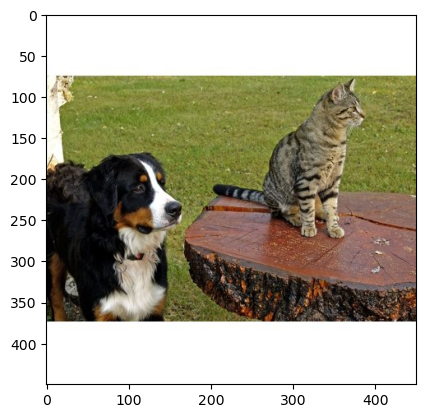

In [7]:
image_to_classify = get_image("./data/dogs.png")
plt.imshow(image_to_classify)

In [8]:
img_tensor = image_to_tensor(image_to_classify)

### **Załadowanie pretrenowanego modelu**

In [9]:
inception_v3 = models.inception_v3(pretrained=True)

C:\Users\Bartek\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Bartek\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### **Predykcja**

In [10]:
inception_v3.eval()
logits = inception_v3(img_tensor)

Zwróć uwagę, że model zwraca wartości funkcji logit, a nie prawdopodobieństwa klas, dlatego wyniki trzeba przetworzyć (np. przy użyciu funkcji softmax).

In [11]:
probas = torch.nn.functional.softmax(logits, dim=1)

Sprawdźmy N najbardziej prawdopodobnych klas

In [12]:
TOP_N_LABELS = 15

probas_top = probas.topk(TOP_N_LABELS)
top_probas = probas_top[0][0].detach().numpy()
top_labels = probas_top[1][0].detach().numpy()
for proba, label in zip(top_probas, top_labels):
    print(f"Class: {index_to_label[label]:<30} | Probability: {proba:.6f}")

Class: Bernese_mountain_dog           | Probability: 0.935930
Class: EntleBucher                    | Probability: 0.038448
Class: Appenzeller                    | Probability: 0.023756
Class: Greater_Swiss_Mountain_dog     | Probability: 0.001818
Class: Gordon_setter                  | Probability: 0.000009
Class: Blenheim_spaniel               | Probability: 0.000007
Class: English_springer               | Probability: 0.000002
Class: tabby                          | Probability: 0.000002
Class: robin                          | Probability: 0.000001
Class: guinea_pig                     | Probability: 0.000001
Class: amphibian                      | Probability: 0.000001
Class: Japanese_spaniel               | Probability: 0.000001
Class: African_grey                   | Probability: 0.000001
Class: Brittany_spaniel               | Probability: 0.000001
Class: toucan                         | Probability: 0.000001


### **Teraz możemy te funkcje zebrać razem**

In [13]:
def get_prediction_probabilities(image, model):
    img_tensor = image_to_tensor(image)
    model.eval()
    logits = model(img_tensor)
    probas = torch.nn.functional.softmax(logits, dim=1)
    
    TOP_N_LABELS = 15

    probas_top = probas.topk(TOP_N_LABELS)
    top_probas = probas_top[0][0].detach().numpy()
    top_labels = probas_top[1][0].detach().numpy()
    for proba, label in zip(top_probas, top_labels):
        print(f"Class: {index_to_label[label]:<30} | Probability: {proba:.6f}")

### **I sprawdzić jak ta predykcja wygląda dla innego obrazka**

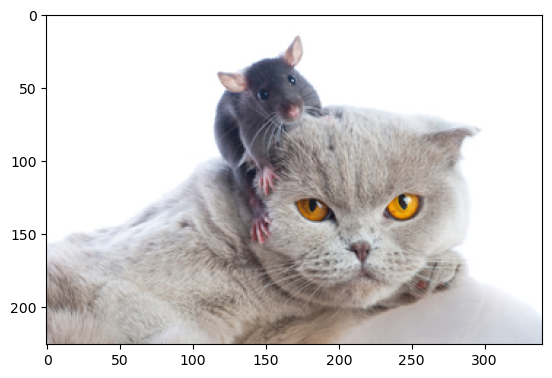

In [14]:
exercise_image = get_image("./data/cat_mouse.jpeg")
plt.imshow(exercise_image)

## **Zadanie: sprawdź jak będzie wyglądała predykcja dla powyższego obrazka**

In [15]:
get_prediction_probabilities(exercise_image, inception_v3)

Class: Egyptian_cat                   | Probability: 0.967491
Class: tabby                          | Probability: 0.024167
Class: lynx                           | Probability: 0.005490
Class: tiger_cat                      | Probability: 0.002165
Class: Persian_cat                    | Probability: 0.000105
Class: Angora                         | Probability: 0.000074
Class: swab                           | Probability: 0.000071
Class: Madagascar_cat                 | Probability: 0.000064
Class: snow_leopard                   | Probability: 0.000040
Class: tile_roof                      | Probability: 0.000037
Class: indri                          | Probability: 0.000020
Class: leopard                        | Probability: 0.000016
Class: Siamese_cat                    | Probability: 0.000011
Class: ram                            | Probability: 0.000010
Class: crate                          | Probability: 0.000009


Z uzyskanych wyników wynika, że najbardziej prawdopodobną klasą jest 'Egyptian_cat'.

# **Model Inception-v3 - wyjaśnienie**

Chcemy wiedzieć dlaczego klasa `Bernese_mountain_dog` została uznana przez sieć neuronową za najbardziej prawdopodobną (to znaczy - które piksele obrazka o tym zadecydowały). W tym celu właśnie wykorzystamy LIME.

W jaki sposób działa LIME na obrazkach?
1. Na wejściu wymagany jest oryginalny obrazek.
2. Wejściowy obrazek jest delikatnie przekształcany wiele razy, dzięki czemu otrzymujemy wiele podobnych (ale nie takich samych!) obrazków.
3. Dodatkowo na wejście musimy podać funkcję, która każdemu takiemu przekształceniu nada prawdopodobieństwo przynależności do danej klasy. Jest to wymagane ponieważ LIME jest niezależny od żadnych narzędzi i modeli.

In [16]:
explainer = lime_image.LimeImageExplainer()

In [17]:
explanation = explainer.explain_instance(
    image=lime_transformer(image_to_classify), 
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

Mając te dane możemy teraz sprawdzić które kategorie są najbardziej prawdopodobne

In [18]:
for index in explanation.top_labels:
    print(index_to_label[index])

Bernese_mountain_dog
EntleBucher
Appenzeller
Greater_Swiss_Mountain_dog
Gordon_setter


Zobaczmy co wpłynęło na wybranie `Bernese_mountain_dog` jako najbardziej prawdopodobnej klasy.

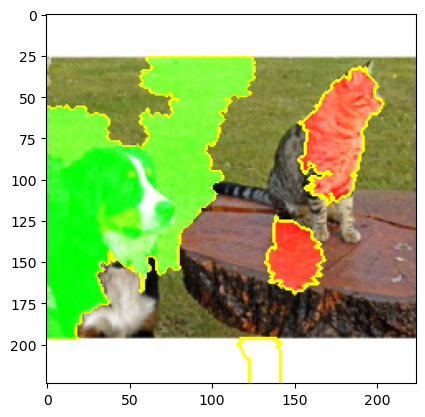

In [19]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

## **Zadanie: zmień wartość NUM_FEATURES i zaobserwuj jak zmienia się mapowanie**
NUM_FEATURES najlepiej zmieniać w zakresie 1:50

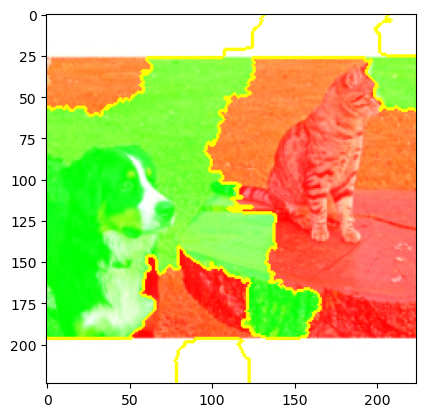

In [20]:
NUM_FEATURES = 40 # 10

image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=NUM_FEATURES,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Zwiększając wartość parametru 'NUM_FEATURES' można zauważyć, że do pewnego momentu zwiększa się liczba zielonych i czerwonych fragmentów obrazu. Oznacza to, że model bierze pod uwagę coraz więcej regionów obrazu. Po przekroczeniu pewnej wartości dodawanych jest coraz mniej istotnych superpikseli, co skutkuje mniej interpretowalnymi wynikami.

Zielone fragmenty oznaczają "superpiksele", które pozytywnie wpływają na predykowaną klasę. Czerwone fragmenty wpływają negatywnie.

## **Zadanie-pytanie: co to właściwie jest superpiksel?**

Superpiksel to grupa sąsiadujących pikseli na obrazie, które są pogrupowane w większe jednostki ze względu na ich podobne właściwości. Pozwalają one 
na zmniejszenie liczby jednostek do analizy obrazu przy jednoczesnym zachowaniu istotnych informacji.

## **Zadanie-pytanie: czy jeden superpiksel ma odzwierciedlenie w jednym pikselu z obrazka?**

Jeden superpiksel ma odzwierciedlenie w jednym pikselu z obrazka, pod warunkiem że wspomniany piksel należy do grupy pikseli tworzących dany superpiksel. Na poziomie analizy obrazu działa on tak, jakby był odpowiednikiem jednego punktu danych, który wpływa na decyzję modelu.

Zobaczmy jak to się prezentuje dla drugiej najbardziej prawdopodobnej klasy, czyli `EntleBucher`, która jednak otrzymała jedyne 3.8%.

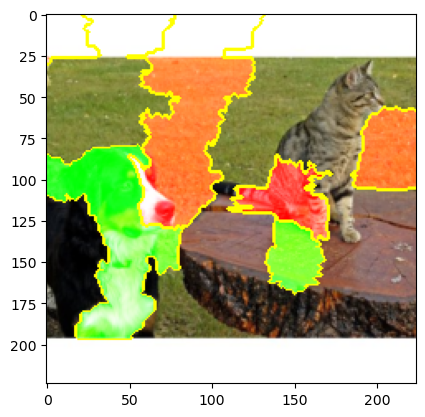

In [21]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[1],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Ustawiając wartości `hide_rest` oraz `positive_only` na `True` jesteśmy w stanie zostawić tylko te piksele, które potwierdzały przynależność do danej klasy <br>
Musimy jednak pamiętać o przeskalowaniu rezultatu przy pomocy `(boundaries).astype(np.uint8)`

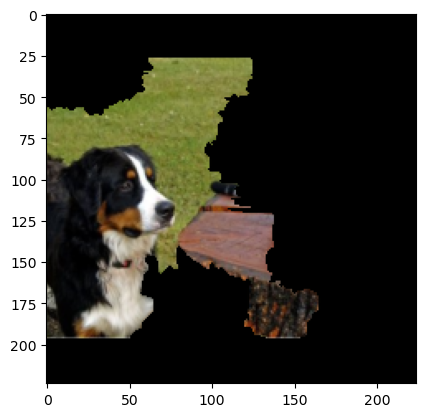

In [22]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=True,
    negative_only=False,
    num_features=10,
    hide_rest=True)
boundaries = mark_boundaries(image, mask)
plt.imshow((boundaries).astype(np.uint8))

Możemy również zostawić tylko te piksele, które zaprzeczały przynależności do danej klasy

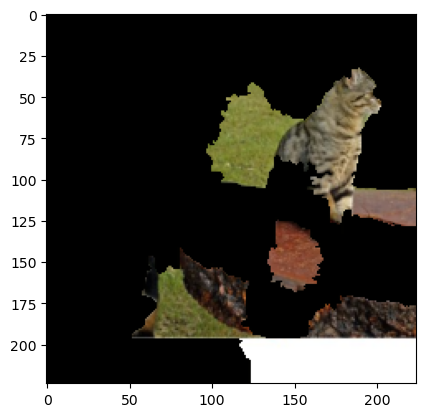

In [23]:
image, mask = explanation.get_image_and_mask(
    label=explanation.top_labels[0],
    positive_only=False,
    negative_only=True,
    num_features=10,
    hide_rest=True)
boundaries = mark_boundaries(image, mask)
cropped_image_ndarray = (boundaries).astype(np.uint8)
plt.imshow(cropped_image_ndarray)

A następnie sprawdzić co model sądzi o tak wyciętym obrazku

In [24]:
cropped_image_pil = Image.fromarray(cropped_image_ndarray)

get_prediction_probabilities(cropped_image_pil, inception_v3)

Class: African_grey                   | Probability: 0.968853
Class: sulphur-crested_cockatoo       | Probability: 0.014763
Class: West_Highland_white_terrier    | Probability: 0.003940
Class: toy_poodle                     | Probability: 0.002781
Class: miniature_poodle               | Probability: 0.002558
Class: feather_boa                    | Probability: 0.001530
Class: teddy                          | Probability: 0.000714
Class: Sealyham_terrier               | Probability: 0.000709
Class: komondor                       | Probability: 0.000457
Class: standard_poodle                | Probability: 0.000301
Class: vulture                        | Probability: 0.000265
Class: Lhasa                          | Probability: 0.000248
Class: hen                            | Probability: 0.000246
Class: Bedlington_terrier             | Probability: 0.000201
Class: Persian_cat                    | Probability: 0.000182


I jak go teraz widzi model

In [25]:
cropped_image_explanation = explainer.explain_instance(
    image=lime_transformer(cropped_image_pil), 
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

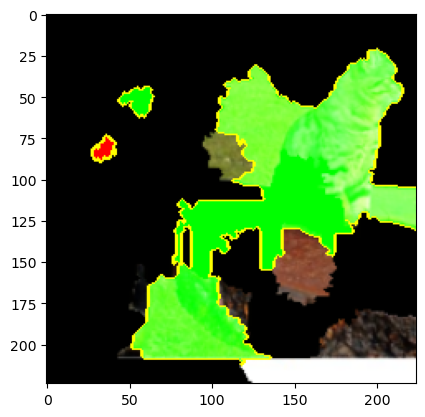

In [26]:
image, mask = cropped_image_explanation.get_image_and_mask(
    label=cropped_image_explanation.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

# **Model Inception-v3 - porównanie z AlexNet**

Przetestujmy działanie na innym modelu - `AlexNet`

In [27]:
alexnet = models.alexnet(pretrained=True)

C:\Users\Bartek\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Bartek\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
explanation_alexnet = explainer.explain_instance(
    image=lime_transformer(image_to_classify), 
    classifier_fn=partial(predict_batch, alexnet),
    top_labels=5,
    num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [29]:
for index_alex, index_inception in zip(explanation_alexnet.top_labels, explanation.top_labels):
    print(f"{index_to_label[index_alex]:30} | {index_to_label[index_inception]:30}")

Bernese_mountain_dog           | Bernese_mountain_dog          
EntleBucher                    | EntleBucher                   
Greater_Swiss_Mountain_dog     | Appenzeller                   
Appenzeller                    | Greater_Swiss_Mountain_dog    
basset                         | Gordon_setter                 


Jak widać, klasy nieco się różnią, ale TOP 1 pozostaje takie samo.

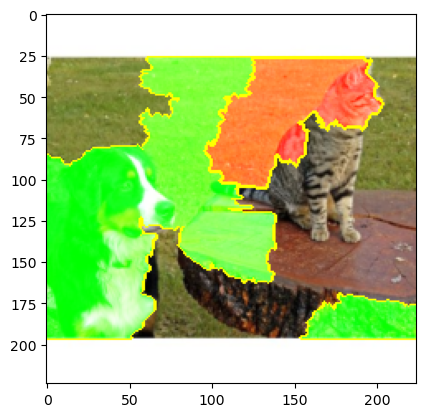

In [30]:
image, mask = explanation_alexnet.get_image_and_mask(
    label=explanation_alexnet.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=10,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Wyjaśnienie dla `AlexNet` jak się można było spodziewać - też się różni, jednak w dalszym ciągu do klasyfikacji psa istotny jest... pies :)

## **Zadanie: porównaj predykcje obrazka dla modeli inception_v3 oraz alexnet**

In [31]:
print("inception_v3")
get_prediction_probabilities(image_to_classify, inception_v3)
print()
print("alexnet")
get_prediction_probabilities(image_to_classify, alexnet)

inception_v3
Class: Bernese_mountain_dog           | Probability: 0.935930
Class: EntleBucher                    | Probability: 0.038448
Class: Appenzeller                    | Probability: 0.023756
Class: Greater_Swiss_Mountain_dog     | Probability: 0.001818
Class: Gordon_setter                  | Probability: 0.000009
Class: Blenheim_spaniel               | Probability: 0.000007
Class: English_springer               | Probability: 0.000002
Class: tabby                          | Probability: 0.000002
Class: robin                          | Probability: 0.000001
Class: guinea_pig                     | Probability: 0.000001
Class: amphibian                      | Probability: 0.000001
Class: Japanese_spaniel               | Probability: 0.000001
Class: African_grey                   | Probability: 0.000001
Class: Brittany_spaniel               | Probability: 0.000001
Class: toucan                         | Probability: 0.000001

alexnet
Class: Bernese_mountain_dog           | Probabil

W przypadku obu modeli najwyżej ocenianą klasą jest 'Bernese_mountain_dog'. Różnica tutaj polega na tym, że model inception_v3 jest bardziej pewny swojej predykcji (prawdopodobieństwo około 94%), podczas gdy model alexnet jest mniej pewny swojej predykcji (prawdopodobieństwo około 40%).

# **Zadanie domowe - wstęp**
W folderze `data` znajduje się zdjęcie tukana. Zgodnie z poleceniem został wybrany własny obraz (inny niż amfibia) z dowolnej klasy rozpoznawanej przez sieć. Wykorzystano obraz spoza zbioru ImageNet, na którym wytrenowana była sieć. Obraz pochodzi z internetowej darmowej galerii Pexels, gdzie twórcy udostępniają swoje zdjęcia, obrazy oraz filmy bez opłat licencyjnych. Zdjecie zostało wykonane w 2022 roku, czyli w czasie kiedy istniał już zbiór ImageNet. Źródło obrazu: https://www.pexels.com/photo/close-up-photo-of-bird-perched-on-tree-branch-11398673/

![title](data/toucan.jpg)


In [32]:
bird = get_image("./data/toucan.jpg")

C:\Users\Bartek\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Bartek\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/1000 [00:00<?, ?it/s]

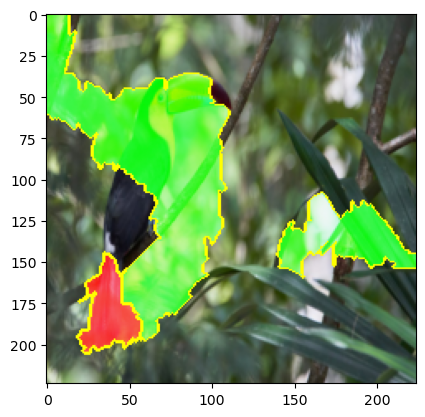

In [33]:
inception_v3 = models.inception_v3(pretrained=True)

explanation_bird_inception_v3 = explainer.explain_instance(
    image=lime_transformer(bird), 
    classifier_fn=partial(predict_batch, inception_v3),
    top_labels=5,
    num_samples=1000)

image, mask = explanation_bird_inception_v3.get_image_and_mask(
    label=explanation_bird_inception_v3.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=8,
    hide_rest=False)
boundaries = mark_boundaries(image, mask)
plt.imshow(boundaries)

Model `inception_v3` jak i jego wyjaśnienie rzeczywiście sugerują tukana jako najbardziej prawdopodobną klasę:

In [34]:
for index in explanation_bird_inception_v3.top_labels:
    print(index_to_label[index])

toucan
hornbill
school_bus
king_penguin
screwdriver


# Zadanie #1

Użyj dwóch różnych sieci neuronowych (poza inception_v3, którego przykład jest powyżej) do wygenerowania wyjaśnień.<br>
(skorzystaj z modułu torchvision: https://pytorch.org/vision/stable/models.html)

**ResNet50**

  0%|          | 0/1000 [00:00<?, ?it/s]

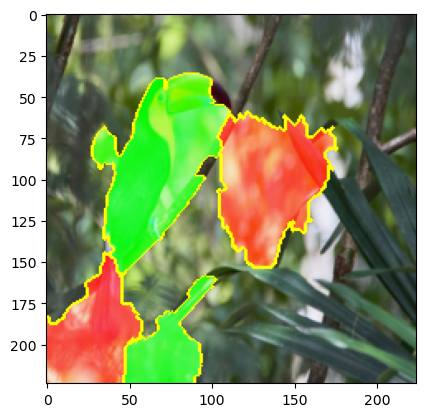

In [35]:
resnet50 = models.resnet50(weights='IMAGENET1K_V2')

explanation_bird_resnet50 = explainer.explain_instance(
    image=lime_transformer(bird),
    classifier_fn=partial(predict_batch, resnet50),
    top_labels=5,
    num_samples=1000)

image_resnet50, mask_resnet50 = explanation_bird_resnet50.get_image_and_mask(
    label=explanation_bird_resnet50.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=8,
    hide_rest=False)

boundaries_resnet50 = mark_boundaries(image_resnet50, mask_resnet50)
plt.imshow(boundaries_resnet50)

In [36]:
for index in explanation_bird_resnet50.top_labels:
    print(index_to_label[index])

toucan
hornbill
magpie
china_cabinet
coucal


Model resnet50 jak i jego wyjaśnienie rzeczywiście sugerują tukana jako najbardziej prawdopodobną klasę.

**DenseNet161**

  0%|          | 0/1000 [00:00<?, ?it/s]

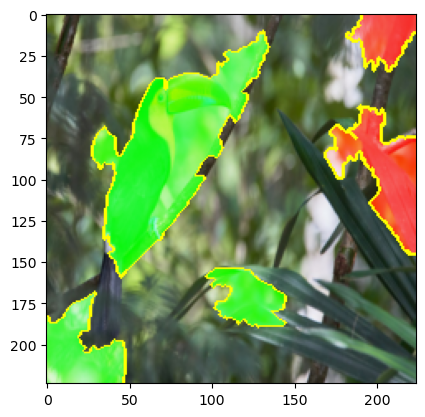

In [37]:
densenet161 = models.densenet161(weights='IMAGENET1K_V1')

explanation_bird_densenet161 = explainer.explain_instance(
    image=lime_transformer(bird),
    classifier_fn=partial(predict_batch, densenet161),
    top_labels=5,
    num_samples=1000)

image_densenet161, mask_densenet161 = explanation_bird_densenet161.get_image_and_mask(
    label=explanation_bird_densenet161.top_labels[0],
    positive_only=False,
    negative_only=False,
    num_features=8,
    hide_rest=False)

boundaries_densenet161 = mark_boundaries(image_densenet161, mask_densenet161)
plt.imshow(boundaries_densenet161)

In [38]:
for index in explanation_bird_densenet161.top_labels:
    print(index_to_label[index])

toucan
hornbill
bee_eater
king_penguin
macaw


Model densenet161 jak i jego wyjaśnienie rzeczywiście sugerują tukana jako najbardziej prawdopodobną klasę.

# Zadanie #2

Zmodyfikuj oryginalny obrazek w taki sposób, żeby najbardziej prawdopodobną klasą dla każdej z tych sieci **nie był** tukan a jakiś inny ptak. W tym celu możesz "zasłonić" czarnym kwadratem (wartość 0 w macierzy reprezentującej obraz) obszary istotne przy klasyfikacji. <br>
Przydatną rzeczą będzie skorzystanie z opcji `hide_rest` w funkcji `get_image_and_mask` i późniejsza obróbka obrazu

**ResNet50**

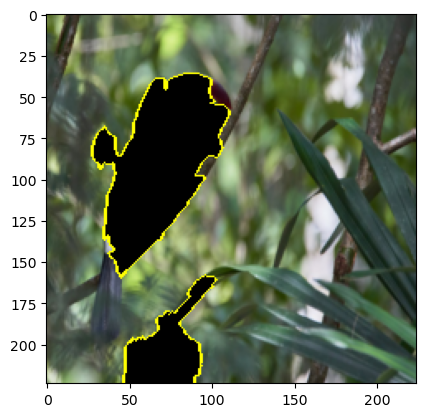

In [40]:
image_resnet50, mask_resnet50 = explanation_bird_resnet50.get_image_and_mask(
    label=explanation_bird_resnet50.top_labels[0],
    positive_only=True,
    negative_only=False,
    num_features=4,
    hide_rest=False)

modified_image_resnet50 = image_resnet50.copy()
modified_image_resnet50[mask_resnet50 == 1] = 0

boundaries_resnet50 = mark_boundaries(modified_image_resnet50, mask_resnet50)
plt.imshow(boundaries_resnet50)

In [41]:
modified_image_resnet50 = Image.fromarray(modified_image_resnet50.astype(np.uint8))

print("resnet50")
get_prediction_probabilities(modified_image_resnet50, resnet50)

resnet50
Class: European_gallinule             | Probability: 0.101171
Class: hornbill                       | Probability: 0.097626
Class: toucan                         | Probability: 0.072013
Class: vulture                        | Probability: 0.021064
Class: house_finch                    | Probability: 0.018672
Class: goldfinch                      | Probability: 0.017910
Class: magpie                         | Probability: 0.016234
Class: lorikeet                       | Probability: 0.015110
Class: hummingbird                    | Probability: 0.012519
Class: black_stork                    | Probability: 0.010743
Class: coucal                         | Probability: 0.010647
Class: macaw                          | Probability: 0.009183
Class: black_grouse                   | Probability: 0.009128
Class: bulbul                         | Probability: 0.008470
Class: jacamar                        | Probability: 0.006364


Model resnet50 jak i jego wyjaśnienie, po modyfikacji obrazu, sugerują European_gallinule jako najbardziej prawdopodobną klasę.

**DenseNet**

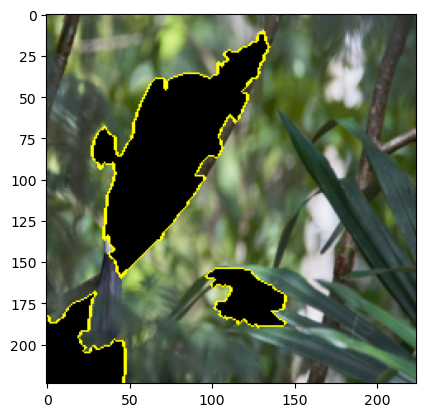

In [43]:
image_densenet161, mask_densenet161 = explanation_bird_densenet161.get_image_and_mask(
    label=explanation_bird_densenet161.top_labels[0],
    positive_only=True,
    negative_only=False,
    num_features=6,
    hide_rest=False)

modified_image_densenet161 = image_resnet50.copy()
modified_image_densenet161[mask_densenet161 == 1] = 0

boundaries_densenet161 = mark_boundaries(modified_image_densenet161, mask_densenet161)
plt.imshow(boundaries_densenet161)

In [44]:
modified_image_densenet161 = Image.fromarray(modified_image_densenet161.astype(np.uint8))

print("densenet161")
get_prediction_probabilities(modified_image_densenet161, densenet161)

densenet161
Class: coucal                         | Probability: 0.259482
Class: toucan                         | Probability: 0.201190
Class: quill                          | Probability: 0.080150
Class: magpie                         | Probability: 0.075107
Class: hornbill                       | Probability: 0.059314
Class: limpkin                        | Probability: 0.055361
Class: vulture                        | Probability: 0.045030
Class: black_stork                    | Probability: 0.044994
Class: kite                           | Probability: 0.031459
Class: European_gallinule             | Probability: 0.014090
Class: bald_eagle                     | Probability: 0.012607
Class: hummingbird                    | Probability: 0.012000
Class: bittern                        | Probability: 0.011722
Class: little_blue_heron              | Probability: 0.011524
Class: jacamar                        | Probability: 0.004920


Model densenet161 jak i jego wyjaśnienie, po modyfikacji obrazu, sugerują coucal jako najbardziej prawdopodobną klasę.

# Zadanie #3

Ponownie zmodyfikuj oryginalny obraz, ale tym razem zaszumiając go w losowy sposób (przykładowa implementacja: https://www.geeksforgeeks.org/add-a-salt-and-pepper-noise-to-an-image-with-python/). Czy najbardziej prawdopodobna klasa zmienia się wraz ze zmianą szumu? Przetestuj dla każdego z modeli.

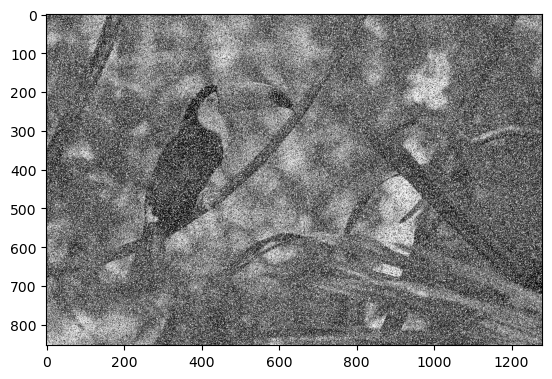

In [45]:
def add_noise(img):
    row, col, _ = img.shape
    number_of_pixels = random.randint(1000, 400000)
    
    for i in range(number_of_pixels):
        y_coord = random.randint(0, row - 1)
        x_coord = random.randint(0, col - 1)
        img[y_coord, x_coord] = 255
    
    number_of_pixels = random.randint(1000, 400000)
    
    for i in range(number_of_pixels):
        y_coord = random.randint(0, row - 1)
        x_coord = random.randint(0, col - 1)
        img[y_coord, x_coord] = 0
    
    return img

modified_bird = cv2.imread("./data/toucan.jpg", cv2.IMREAD_GRAYSCALE) 
modified_bird = cv2.cvtColor(modified_bird, cv2.COLOR_BGR2RGB)
modified_bird = add_noise(modified_bird)

plt.imshow(modified_bird)

In [46]:
modified_bird = Image.fromarray(modified_bird.astype(np.uint8))

print("inception_v3")
get_prediction_probabilities(modified_bird, inception_v3)
print()
print("resnet50")
get_prediction_probabilities(modified_bird, resnet50)
print()
print("densenet161")
get_prediction_probabilities(modified_bird, densenet161)

inception_v3
Class: quail                          | Probability: 0.776598
Class: weevil                         | Probability: 0.020417
Class: toucan                         | Probability: 0.007665
Class: African_grey                   | Probability: 0.004659
Class: macaw                          | Probability: 0.004246
Class: robin                          | Probability: 0.004097
Class: vulture                        | Probability: 0.003831
Class: peacock                        | Probability: 0.003604
Class: indigo_bunting                 | Probability: 0.003570
Class: timber_wolf                    | Probability: 0.003233
Class: kite                           | Probability: 0.002840
Class: black_stork                    | Probability: 0.002763
Class: African_chameleon              | Probability: 0.002687
Class: bald_eagle                     | Probability: 0.002518
Class: ruffed_grouse                  | Probability: 0.002475

resnet50
Class: quail                          | Probabi

W zadaniu testowano 3 modele tj.: inception_v3, resnet50 oraz densenet161. We wszystkich przypadkach, przy zmianie szumu, najbardziej prawdopodobna klasa ulegała zmianie.